In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
####### define the parameter space
param_lim_origin = {}
param_lim_origin['Omegab'] = [0.04, 0.06]
param_lim_origin['H0'] = [60, 80]
param_lim_origin['ns'] = [0.92, 1.00]
param_lim_origin['wa'] = [-0.5, 0.5]
param_lim_origin['mnu'] = [0, 0.3]
param_lim_origin['w'] = [-1.3, -0.7]
param_lim_origin['Omegam'] = [0.24, 0.40]
param_lim_origin['A'] = [1.7, 2.5]  # 1e-9

mean_samp_p18_lcdm = {'Omegab': 0.04897468,
                      'Omegam': 0.30969282,
                      'H0': 67.66,
                      'A': 2.105,
                      'ns': 0.9665,
                      'w': -1.0,
                      'wa': 0.0,
                      'mnu': 0.06}

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import scienceplots
# import pyccl
# from classy import Class, CosmoSevereError

In [4]:
####### trainning sample
from scipy.stats import qmc
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from copy import deepcopy
from multiprocessing import Pool
from functools import partial

k_list = np.load('data/pk_k_list.npy')

def ConstructSpaceTest(ntest=50):
    n_param = 8
    cosmo_train = np.load('data/cosmologies_8d_train_n129_Sobol.npy')
    pk_cb_lin_all   = np.load('data/pk_cb_lin_train_n129_Sobol.npy') 
    pk_cb_nl_all    = np.load('data/pk_cb_nl_train_n129_Sobol.npy' )
#     cosmo_valid = np.load('data/cosmologies_8d_validate_n1022_Sobol_scramble.npy')[:ntest, :]
#     pk_cb_lin_outer = np.load('data/pk_cb_lin_validate_n1022_Sobol_scramble.npy')[:ntest, :,:] 
#     pk_cb_nl_outer  = np.load('data/pk_cb_nl_validate_n1022_Sobol_scramble.npy' )[:ntest, :,:]
    cosmo_valid = np.load('data/cosmologies_8d_validate_n{:d}_LH.npy'.format(ntest))
    pk_cb_lin_outer = np.load( 'data/pk_cb_lin_validate_n{:d}_LH.npy'.format(ntest))
    pk_cb_nl_outer  = np.load(  'data/pk_cb_nl_validate_n{:d}_LH.npy'.format(ntest))
    Bk_cb_all = pk_cb_nl_all/pk_cb_lin_all
    Bk_cb_outer = pk_cb_nl_outer/pk_cb_lin_outer

    def MyPredicted(para_trainning_in, para_validate_in, Bk_trainning, usePCA=False, **hyperpara):
        ### normalize parameters
        para_min = np.min(para_trainning_in, axis=0)
        para_max = np.max(para_trainning_in, axis=0)
        para_trainning = np.zeros_like(para_trainning_in)
        para_validate  = np.zeros_like(para_validate_in)
        for i_dim in range(para_trainning_in.shape[1]):
            para_trainning[:,i_dim] = (para_trainning_in[:,i_dim] - para_min[i_dim])/(para_max[i_dim]-para_min[i_dim])
            para_validate [:,i_dim] = (para_validate_in [:,i_dim] - para_min[i_dim])/(para_max[i_dim]-para_min[i_dim])

        ###### GP setups
        rand_seed = np.random.RandomState(seed=100318)
#         gpr = GaussianProcessRegressor(normalize_y=True, random_state=rand_seed, **hyperpara)
        gpr = make_pipeline(preprocessing.StandardScaler(), GaussianProcessRegressor(normalize_y=True, random_state=rand_seed, **hyperpara))
        if usePCA:
            nvec = 14
            pca = PCA(n_components=nvec, svd_solver='full')
            pca.fit(Bk_trainning);
            Bkcoeff = pca.transform(Bk_trainning)
    #         print(Bkcoeff.shape)
            coeff_predited = np.zeros((para_validate.shape[0], nvec))
            for ivec in range(nvec):
                fitting = gpr.fit(para_trainning, Bkcoeff[:,ivec]);
                coeff_predited[:,ivec] = gpr.predict(para_validate);
    #             print("{:d}-th component: ".format(ivec), gpr.kernel_)
            Bk_predited = pca.inverse_transform(coeff_predited);        
        else:
            fitting = gpr.fit(para_trainning, Bk_trainning)
            Bk_predited = gpr.predict(para_validate)
    #     print(gpr.kernel_)
        return Bk_predited

    kernel = ConstantKernel(1)*RBF(np.ones((n_param)), length_scale_bounds=(1e-15, 1e15))
    # kernel = ConstantKernel(2)*Matern(np.ones((n_param)))
    usePCA = True

    # ax0 = plt.subplot(gridp[0, 0])
    n_sample = 33
    Bk_predicted = 10**MyPredicted(para_trainning_in=cosmo_train[:n_sample,:], 
                                   Bk_trainning=np.log10(Bk_cb_all[:n_sample,0,:]), 
                                   para_validate_in=cosmo_valid, 
                                   usePCA=usePCA, kernel=kernel, n_restarts_optimizer=10)
    pk_cb_nl_predicted1 = Bk_predicted*pk_cb_lin_outer[:,0,:]
    std_predicted1 = np.std(pk_cb_nl_predicted1/pk_cb_nl_outer[:,0,:], axis=0)
    mean_predicted1 = np.mean(pk_cb_nl_predicted1/pk_cb_nl_outer[:,0,:], axis=0)

    n_sample = 65
    Bk_predicted = 10**MyPredicted(para_trainning_in=cosmo_train[:n_sample,:], 
                               Bk_trainning=np.log10(Bk_cb_all[:n_sample,0,:]), 
                               para_validate_in=cosmo_valid, 
                               usePCA=usePCA, kernel=kernel, n_restarts_optimizer=10)
    pk_cb_nl_predicted2 = Bk_predicted*pk_cb_lin_outer[:,0,:]
    std_predicted2 = np.std(pk_cb_nl_predicted2/pk_cb_nl_outer[:,0,:], axis=0)
    mean_predicted2 = np.mean(pk_cb_nl_predicted2/pk_cb_nl_outer[:,0,:], axis=0)

    n_sample = 129
    Bk_predicted = 10**MyPredicted(para_trainning_in=cosmo_train[:n_sample,:], 
                               Bk_trainning=np.log10(Bk_cb_all[:n_sample,0,:]), 
                               para_validate_in=cosmo_valid, 
                               usePCA=usePCA, kernel=kernel, n_restarts_optimizer=10)
    pk_cb_nl_predicted3 = Bk_predicted*pk_cb_lin_outer[:,0,:]
    std_predicted3 = np.std(pk_cb_nl_predicted3/pk_cb_nl_outer[:,0,:], axis=0)
    mean_predicted3 = np.mean(pk_cb_nl_predicted3/pk_cb_nl_outer[:,0,:], axis=0)
    return std_predicted1, std_predicted2, std_predicted3,pk_cb_nl_predicted1,pk_cb_nl_predicted2,pk_cb_nl_predicted3

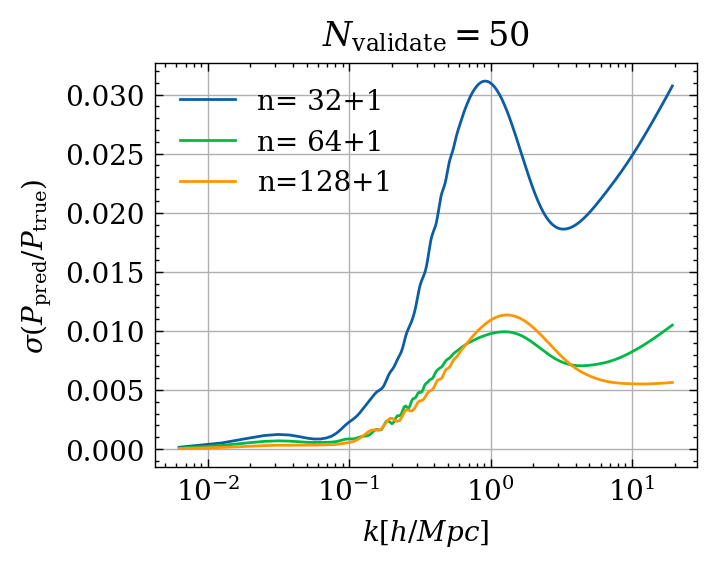

In [5]:
ntest = 50
std_predicted1, std_predicted2, std_predicted3,pk_pred1,pk_pred2,pk_pred3 = ConstructSpaceTest(ntest)

with plt.style.context(['science', 'no-latex']):
    plt.plot(k_list, std_predicted1, label="n= 32+1")
    plt.plot(k_list, std_predicted2, label="n= 64+1")
    plt.plot(k_list, std_predicted3, label="n=128+1")
    plt.xscale('log')
    plt.legend()
    plt.title(r'$N_\mathrm{validate} = %d$'%(ntest))
    plt.grid('on')
    plt.xlabel(r'$k [h/Mpc]$')
    plt.ylabel(r'$\sigma(P_\mathrm{pred}/P_\mathrm{true})$')

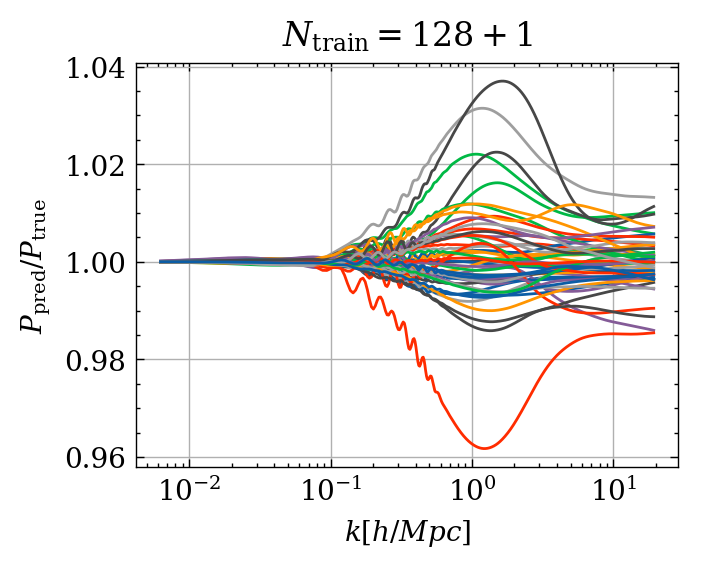

In [6]:
pk_outer = np.load('data/pk_cb_nl_validate_n{:d}_LH.npy'.format(ntest))
with plt.style.context(['science', 'no-latex']):
    for ii in range(50):
        plt.semilogx(k_list, pk_pred3[ii, :]/pk_outer[ii,0, :])
    plt.title(r'$N_\mathrm{train} = %d + 1$'%(128))
    plt.grid('on')
    plt.xlabel(r'$k [h/Mpc]$')
    plt.ylabel(r'$P_\mathrm{pred}/P_\mathrm{true}$')

In [ ]:
## leave-one-out error